<a href="https://colab.research.google.com/github/lostapple9/CovidLungDetectionModel/blob/lostapple9-patch-1/CovidLungDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import gc
import random
import matplotlib.pyplot as plt
import numpy as np
from cv2 import resize, imread, IMREAD_COLOR, IMREAD_GRAYSCALE, INTER_CUBIC
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

covid_set = ['/content/drive/MyDrive/covid19_lung_data/{}'.format(i) for i in os.listdir('/content/drive/MyDrive/covid19_lung_data')]
normal_set = ['/content/drive/MyDrive/normal_lung_data/{}'.format(i) for i in os.listdir('/content/drive/MyDrive/normal_lung_data')]


FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(normal_set)
print(covid_set)

In [ ]:
total = normal_set + covid_set
random.shuffle(total)

In [ ]:
split = 0.8
slice_reserve = 10;
slice_total = len(normal_set)
slice_list_max = slice_total - slice_reserve
slice_list = int(slice_list_max*split)

train_set = total[:slice_list]
test_set = total[slice_list: slice_list_max]
reserve_set = total[slice_list_max: slice_total]


In [ ]:

del covid_set,normal_set
gc.collect()

In [ ]:
width = 250
height = 250



In [ ]:
X_train = []
X_test = []
X_reserve = []

y_train = []
y_test = []
y_reserve = []


In [ ]:
# a 0 label indicates positive covid pneumonia
# a 1 label indicates no pneumonia
def preprocess_image_set(data_set):
  X_set = []
  y_set = []
  for image in data_set:
    try:
      X_set.append(resize(imread(image), (width, height), interpolation = INTER_CUBIC))
      if 'COVID-' in image:
        y_set.append(0)
      else:
        y_set.append(1)
    except Exception:
      print('failed to format: ', image)
  return X_set, y_set

In [ ]:
def show_images(image_set, label_set):
  plt.figure(figsize = (10,10))
  for i in range(9):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(image_set[i])
    plt.title(label_set[i])
    plt.axis("off")


In [ ]:
X_train, y_train = preprocess_image_set(train_set)

In [ ]:
# show the first 10 images from training set
# 1 = no covid, 0 = has covid
show_images(X_train, y_train)

In [ ]:
X_test, y_test = preprocess_image_set(test_set)

In [ ]:
X_reserve, y_reserve = preprocess_image_set(reserve_set)

In [ ]:
del train_set, test_set, reserve_set
gc.collect()

In [ ]:
# translate lists into numpy arrays
X_train =  np.array(X_train)
X_test = np.array(X_test)
X_reserve =  np.array(X_reserve)

y_train = np.array(y_train)
y_test = np.array(y_test)


In [ ]:

model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation = 'relu', input_shape = (width, height,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size = 3, activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256, kernel_size = 3, activation = 'relu'))
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(600, activation = 'relu'))
model.add(Dense(200, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
print(model.summary())

In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
history = model.fit(X_train,y_train, validation_data = (X_test, y_test), epochs = 15)

In [ ]:
history.history['accuracy']

In [ ]:
# make label predictions on unseen data
y_predict = model.predict(X_reserve[:slice_reserve])
y_pred = (y_predict > 0.5)

In [ ]:
y_pred = y_pred.tolist()

In [ ]:
y_predict = y_predict.tolist()
y_predict

In [ ]:
y_reserve

In [ ]:
for i in range(len(y_predict)):
  print("predicted result: %0.5f percent probability does not have covid" % (y_predict[i][0]*100))
  if(y_reserve[i] == 0):
    print("Actual result: has covid")
  else:
    print("Actual result: does not have covid")
  print()


In [ ]:
# show the images from reserve set
# 1 = no covid, 0 = covid

show_images(X_reserve, y_reserve)


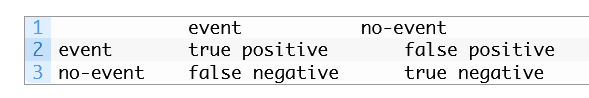


In [ ]:
from sklearn.metrics import confusion_matrix

#event = has covid
#no-event = does not have covid
model_metric = confusion_matrix(y_reserve, y_pred)

In [ ]:
accuracy = (model_metric[0][0] + model_metric[1][1])/ (sum(map(sum, model_metric)))
accuracy